</p>-inputting train_enhanced_cleaned data vs raw data in baseline </p>
<p>-adding custom schedule [improved learning]</p>
<p>-adjusting hyperparameters, d_model =100, droprate =  0.2</p>
<p>-adding attention weights to output for viz </p>
<p>-extracted pre-training word embeddings/post embedding weights to output for viz </p>


<style>
td {
  text-align: center;
}

th {
  text-align: center;
}
</style>

## Setup

The following codes ensures the words embeddings have the same result after being randomly initialized

In [ ]:
import tensorflow as tf
import numpy as np

# Set the seed for random number generation
seed_value = 42
tf.random.set_seed(seed_value)
np.random.seed(seed_value)



In [ ]:

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Navigate to the Directory Containing the CSV File
import os
os.chdir('/content/drive/My Drive/DS266 Project')

Begin by installing [TensorFlow Datasets](https://tensorflow.org/datasets) for loading the dataset and [TensorFlow Text](https://www.tensorflow.org/text) for text preprocessing:

In [ ]:
# Install the most re version of TensorFlow to use the improved
# masking support for `tf.keras.layers.MultiHeadAttention`.
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2 -q
!pip uninstall -y -q tensorflow keras tensorflow-estimator tensorflow-text -q
!pip install -q protobuf~=3.20.3
!pip install -q tensorflow_datasets
!pip install -q -U tensorflow-text tensorflow

Reading package lists...
Building dependency tree...
Reading state information...
Package libcudnn8 is not available, but is referred to by another package.
This may mean that the package is missing, has been obsoleted, or
is only available from another source

E: Version '8.1.0.77-1+cuda11.2' for 'libcudnn8' was not found
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 44.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 93.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 86.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 91.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 66.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 35.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This beh

In [ ]:
# Install compatible TensorFlow version
!pip uninstall tensorflow -y -q
!pip install tensorflow==2.15 -q

# Reinstall tf-keras to resolve any potential dependency conflicts
!pip uninstall tf-keras -y -q
!pip install tf-keras -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 50.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 87.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 44.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 63.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-text 2.16.1 requires tensorflow<2.17,>=2.16.1; platform_machine != "arm64" or platform_system != "Darwin", but you have tensorflow 2.15.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 25.6 MB/s eta 0:00:00


In [ ]:
!pip install tensorflow==2.15 -q #it needs it again for some reason

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-text 2.16.1 requires tensorflow<2.17,>=2.16.1; platform_machine != "arm64" or platform_system != "Darwin", but you have tensorflow 2.15.0 which is incompatible.
tf-keras 2.16.0 requires tensorflow<2.17,>=2.16, but you have tensorflow 2.15.0 which is incompatible.


In [ ]:
!pip uninstall tensorflow-text -y -q
!pip install tensorflow-text==2.15 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 54.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 70.8 MB/s eta 0:00:00


Import the necessary modules:

In [ ]:
import logging
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf

import tensorflow_text as text
from tensorflow import keras

## Data handling



### Download the dataset

read the data

In [ ]:
# Read the CSV File
import pandas as pd
load_data = 'train_enhanced_cleaned.csv'
tweets_df = pd.read_csv(load_data)
tweets_df.head(3)

,text,target
0,location our deeds are the reason of this ea...,1
1,location forest fire near la ronge sask can...,1
2,location all residents asked to shelter in p...,1


### Set up the tokenizer

Now that you have loaded the dataset, you need to tokenize the text, so that each element is represented as a [token](https://developers.google.com/machine-learning/glossary#token) or token ID (a numeric representation).

Tokenization is the process of breaking up text, into "tokens". Depending on the tokenizer, these tokens can represent sentence-pieces, words, subwords, or characters. To learn more about tokenization, visit [this guide](https://www.tensorflow.org/text/guide/tokenizers).

In [ ]:
sentences = tweets_df['text']
labels = tweets_df['target']

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Instantiate the tokenizer
tokenizer = Tokenizer()

# Fit the tokenizer on your text data
tokenizer.fit_on_texts(sentences)


In [ ]:
MAX_TOKENS =30
# Convert sentences to sequences
sequences = tokenizer.texts_to_sequences(sentences)

# Pad sequences
sequences = pad_sequences(sequences, maxlen=MAX_TOKENS, padding='post')

# Convert labels to NumPy array
"""
for i in range(4):
  print(sequences[i].shape)
  print(sequences[i])
  print(sequences[i].dtype)
  print(type(sequences[i]))

print(sequences.shape)
print(type(sequences))
"""

'\nfor i in range(4):\n  print(sequences[i].shape)\n  print(sequences[i])\n  print(sequences[i].dtype)\n  print(type(sequences[i]))\n\nprint(sequences.shape)\nprint(type(sequences))\n'

### Set up a data pipeline with `tf.data`

The following function takes batches of text as input, and converts them to a format suitable for training.

1. It tokenizes them into ragged batches.
2. It trims each to be no longer than `MAX_TOKENS`.
3. It splits the target (English) tokens into inputs and labels. These are shifted by one step so that at each input location the `label` is the id of the next token.
4. It converts the `RaggedTensor`s to padded dense `Tensor`s.
5. It returns an `(inputs, labels)` pair.


In [ ]:
from sklearn.model_selection import train_test_split
# Shuffle and batch the dataset
BUFFER_SIZE = len(sequences)
BATCH_SIZE = 64  # You can adjust the batch size as needed

# Split the data
sequences_train, sequences_val, labels_train, labels_val = train_test_split(sequences, labels, test_size=0.3)

# Convert to TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((sequences_train, labels_train))
val_dataset = tf.data.Dataset.from_tensor_slices((sequences_val, labels_val))

# Shuffle and batch the datasets
train_dataset = train_dataset.shuffle(len(sequences_train)).batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)




## Test the Dataset

In [ ]:
# For train_batches
for x, y in train_dataset.take(1):  # We only take one batch
    print("Shape of X:", x.shape)
    print("Data type of X:", x.dtype)  # This will print the data type
    print("Content of X:", x.numpy())  # .numpy() converts the tensor to a numpy array
    print("Shape of Y:", y.shape)
    print("Content of Y:", y.numpy())

# For val_batches
for x, y in val_dataset.take(1):  # We only take one batch
    print("Shape of X:", x.shape)
    print("Data type of X:", x.dtype)  # This will print the data type
    print("Content of X:", x.numpy())  # .numpy() converts the tensor to a numpy array
    print("Shape of Y:", y.shape)
    print("Content of Y:", y.numpy())

Shape of X: (64, 30)
Data type of X: <dtype: 'int32'>
Content of X: [[    4   330   128 ...     0     0     0]
 [    4   293   972 ...     0     0     0]
 [ 7955  4949    52 ...     6     5    19]
 ...
 [    4   255 14590 ...     0     0     0]
 [    4   454   454 ...     0     0     0]
 [    4   153  3760 ...     0     0     0]]
Shape of Y: (64,)
Content of Y: [0 1 0 1 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 1 1 1 0 1 1 0 1 0 1 0 1 1 1 0 0 0 0
 1 0 0 1 1 1 1 1 0 1 0 1 0 1 0 0 0 1 0 0 0 0 1 0 0 0 1]
Shape of X: (64, 30)
Data type of X: <dtype: 'int32'>
Content of X: [[    4   259    48 ...     0     0     0]
 [    4   216     9 ...     5    22     0]
 [    4    91 15093 ...     0     0     0]
 ...
 [    4   367     2 ...     0     0     0]
 [    4   256   179 ...     0     0     0]
 [    4   105   392 ...     0     0     0]]
Shape of Y: (64,)
Content of Y: [1 0 1 0 0 0 1 1 0 1 1 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 1 1 0 0 0 0 1 1 0 1
 0 0 0 0 1 0 1 0 1 1 0 1 1 0 1 1 0 0 0 1 0 1 0 0 0 1 0]


In [ ]:
for tweet, labels in train_dataset.take(1):
  break

print(tweet.shape)
print(labels.shape)


(64, 30)
(64,)


###Location of Saved Training

Save the models, and files, if directory does not exist, it creates it.

In [ ]:
checkpoint_dir = './Final_Work/enhanced_cleaned_data_base_tx_model_2_heads/'
directory = checkpoint_dir

if not os.path.exists(directory):
    os.makedirs(directory)


 </section>

## Define the components

### The embedding and positional encoding layer

In [ ]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1)

  return tf.cast(pos_encoding, dtype=tf.float32)

The position encoding function is a stack of sines and cosines that vibrate at different frequencies depending on their location along the depth of the embedding vector. They vibrate across the position axis.

In [ ]:
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)
    #the line below is new
    #self.pos_encoding = tf.cast(self.pos_encoding, tf.float64)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    #x, _ = x #ignore attn weights
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    #x *= tf.math.sqrt(tf.cast(self.d_model, tf.float64))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    #print("positionalembedding: shape and type:")
    #the casting is new
    #x = tf.cast(x, tf.float64)
    #print(x.dtype)
    #print(tf.shape(x)[1])
    return x

To implement these attention layers, start with a simple base class that just contains the component layers. Each use-case will be implemented as a subclass. It's a little more code to write this way, but it keeps the intention clear.

In [ ]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

In [ ]:
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output, attn_scores = self.mha(
        query=x,
        value=x,
        key=x,
        return_attention_scores=True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)

    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores

    return x

The network consists of two linear layers (`tf.keras.layers.Dense`) with a ReLU activation in-between, and a dropout layer. As with the attention layers the code here also includes the residual connection and normalization:

In [ ]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x)
    return x


Test the layer, the output is the same shape as the input:

### The encoder layer

Here is the definition of the `EncoderLayer`:

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):

    #print(f"Shape of inputs to encoder layer: {x.shape}")  # Add this line
    x = self.self_attention(x)
    #print(f"Shape after self_attention: {x.shape}")  # Add this line

    x = self.ffn(x)
    return x

  @property
  def last_attn_scores(self):
    return self.self_attention.last_attn_scores

And a quick test, the output will have the same shape as the input:

### The encoder

The encoder consists of:

- A `PositionalEmbedding` layer at the input.
- A stack of `EncoderLayer` layers.

In [ ]:

class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, d_model=d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    #print(f"Shape of inputs to encoder: {x.shape}")  # Add this line
    x = self.pos_embedding(x)
    #print(f"Shape after pos_embedding: {x.shape}")  # Add this line


    # Add dropout.
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    #print("length: ", x.dtype)
    return x  # Shape `(batch_size, seq_len, d_model)`.


  @property
  def last_attn_scores(self):
    return self.enc_layers[-1].last_attn_scores


Test the encoder:

In [ ]:
# Instantiate the encoder.
sample_encoder = Encoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=len(tokenizer.word_index) + 1
)

sample_encoder_output = sample_encoder(tweet, training=False)

# Print the shape.
print(tweet.shape)
print(sample_encoder_output[0].shape)  # Shape `(batch_size, input_seq_len, d_model)`.
print(sample_encoder_output[0].dtype)

(64, 30)
(30, 512)
<dtype: 'float32'>


Having created the Transformer encoder, it's time to build the Transformer model and train it.

## The Transformer Classifier

##This model is based on last hidden state

In [ ]:
class TransformerClassifier(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, dropout_rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)

    self.final_layer = tf.keras.layers.Dense(1, activation='sigmoid')

  def call(self, inputs):
    # To use a Keras model with `.fit` you must pass all your inputs in the
    # first argument.
    context = inputs
    #print(f"Shape of inputs to transformer: {inputs.shape}")  # Add this line
    #print(f"Shape of inputs to transformer: {inputs.dtype}")  # Add this line
    #print((f"end printing shapes and type of input"))

    context = self.encoder(context)  # (batch_size, context_len, d_model)
    logits = self.final_layer(context[:, -1, :])  # Use the last hidden state
    #print(f"end transformer")  # Add this line
    return logits



# Try it out

###Location of Saved Model and Results

In [ ]:
checkpoint_dir = './Final_Work/enhanced_cleaned_data_base_tx_4_heads_dsize_30/'
checkpoint_dir

'./Final_Work/enhanced_cleaned_data_base_tx_4_heads_dsize_30/'

In [ ]:
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)


### Hyperparameters



The base model described in the original Transformer paper used `num_layers=6`, `d_model=512`, and `dff=2048`.

The number of self-attention heads remains the same (`num_heads=8`).

We save the hyperparameters on the drive with the same trained model


In [ ]:

# Specify the path where you want to save the CSV
save_path = './'+checkpoint_dir+'/hyperparameters.csv'


hyperparameters = {
    'num_layers': 2,
    'd_model': 30,
    'dff': 512,
    'num_heads': 2,
    'dropout_rate': 0.3
}

# Convert the hyperparameters dictionary to a DataFrame
hyperparameters_df = pd.DataFrame([hyperparameters])

# Save the DataFrame to a CSV file
hyperparameters_df.to_csv(save_path, index=False)


In [ ]:
# Load the hyperparameters from the CSV file
loaded_hyperparameters_df = pd.read_csv(save_path)

# Access the hyperparameters
loaded_hyperparameters = loaded_hyperparameters_df.iloc[0].to_dict()

#HYPERPARAMETERS
num_layers = int(loaded_hyperparameters['num_layers'])
d_model = int(loaded_hyperparameters['d_model'])
num_heads = int(loaded_hyperparameters['num_heads'])
dff = int(loaded_hyperparameters['dff'])
dropout_rate = float(loaded_hyperparameters['dropout_rate'])


###Instantiate the `Transformer` model:

In [ ]:

transformer = TransformerClassifier(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size= len(tokenizer.word_index) + 1,
    dropout_rate=dropout_rate)


####Extract initial weights

Build the transformer to extract initial word weights (for later analysis)

In [ ]:

# Build the transformer to initialize weights
transformer.build(input_shape=(None, MAX_TOKENS))

# Access the weights of the embedding layer within the PositionalEmbedding layer
initial_embeddings = transformer.encoder.pos_embedding.embedding.get_weights()[0]


The words size list is dependent on the data wrangling done before it. If the data warngling and tokenization doesnt change then the embeddings will not change, and we can start loading hte embeddings instead of randomly creating them on start.

In [ ]:
initial_embeddings.shape

(17984, 30)

####Name the Model

In [ ]:
#model created with cleaned enhanced data set and initialize with randome ebeddings and 4 attention heads and 2 layers
model_base_name = 'cl_enh_dat_bl_tx_w_rand_embed_dsize_30'

####Create Readme File

In [ ]:


# Assuming 'initial_embeddings' contains the weights from the embedding layer
initial_embeddings_df = pd.DataFrame(initial_embeddings)
save_to = checkpoint_dir + 'initial_embeddings.csv'
initial_embeddings_df.to_csv(save_to, index=False)
# Define the directory and file name
directory = checkpoint_dir
file_name = 'initial_embeddings.csv'


readme_content = f"""README

The initial word embeddings before training are saved in the '{directory}' directory.
The file '{file_name}' contains the embeddings in CSV format.

These embeddings are initialized at random and are set to be reproducible using a specific random seed (44).
These randome word embeddings are associated with the model checkpoints saved during training pertaining to models with
base name '{model_base_name}', this word embeddings
can be used for a pre- and post- training analysis of the training effects to each word embedding.

The hyperparameters for this model ara saved on this directory in hyperparameters.csv file
The results of this training run will be saved under CSV_Results-{model_base_name }'.csv file.
The learning schedule plot, training loss plot and training model summary will also saved in this directory.
"""

# path
readme_file_path = f'{directory}/readme.txt'

# Write the readme content to the file
with open(readme_file_path, 'w') as readme_file:
    readme_file.write(readme_content)

# Print a success message
print(f"The readme.txt file has been successfully written to the '{directory}' directory.")

print(readme_content)

The readme.txt file has been successfully written to the './Final_Work/enhanced_cleaned_data_base_tx_4_heads_dsize_30/' directory.
README

The initial word embeddings before training are saved in the './Final_Work/enhanced_cleaned_data_base_tx_4_heads_dsize_30/' directory.
The file 'initial_embeddings.csv' contains the embeddings in CSV format.

These embeddings are initialized at random and are set to be reproducible using a specific random seed (44).
These randome word embeddings are associated with the model checkpoints saved during training pertaining to models with
base name 'cl_enh_dat_bl_tx_w_rand_embed_dsize_30', this word embeddings
can be used for a pre- and post- training analysis of the training effects to each word embedding.

The hyperparameters for this model ara saved on this directory in hyperparameters.csv file
The results of this training run will be saved under CSV_Results-cl_enh_dat_bl_tx_w_rand_embed_dsize_30'.csv file. 
The learning schedule plot, training loss p

####Plotting Tool and Saving History

In [ ]:
def plot_history(history, checkpoint_dir):
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.xticks(range(0, len(history['loss'] + 1)))
  plt.plot(history['loss'], label="training", marker='o')
  plt.plot(history['val_loss'], label="validation", marker='o')
  plt.legend()
  plt.savefig(checkpoint_dir+'loss_history_plot.png')
  plt.show()

In [ ]:
def history_to_csv(history, num_layers, d_model, num_heads, dff, dropout_rate, model_base_name, load_data, checkpoint_dir):
    # Assuming 'history' is your DataFrame
    history_copy = history.copy(deep=True)

    # Add 'Epoch' column
    history_copy['Epoch'] = range(1, len(history_copy) + 1)

    # Add hyperparameters
    history_copy['num_layers'] = num_layers
    history_copy['d_model'] = d_model
    history_copy['num_heads'] = num_heads
    history_copy['dff'] = dff
    history_copy['dropout_rate'] = dropout_rate

    # Add 'name' and 'data' columns
    history_copy['name'] = model_base_name
    history_copy['data'] = load_data

    # Save to CSV
    csv_file_name = "CSV_Results-" + model_base_name + ".csv"
    csv_file_path = os.path.join(checkpoint_dir, csv_file_name)
    history_copy.to_csv(csv_file_path, index=False)

####Print the summary of the model:

In [ ]:
#print(transformer.summary())

with open(checkpoint_dir+'model_summary.txt', 'w') as f:
    transformer.summary(print_fn=lambda x: f.write(x + '\n'))
print(transformer.summary())


Model: "transformer_classifier_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_9 (Encoder)         multiple                  617104    
                                                                 
 dense_55 (Dense)            multiple                  31        
                                                                 
Total params: 617135 (2.35 MB)
Trainable params: 617135 (2.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


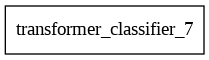

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(transformer, to_file="model_diagram.png", show_shapes=True, show_layer_names=True)

# Training

It's time to prepare the model and start training it.

### Set up the optimizer

Use the Adam optimizer with a custom learning rate scheduler according to the formula in the original Transformer [paper](https://arxiv.org/abs/1706.03762).

$$\Large{lrate = d_{model}^{-0.5} * \min(step{\_}num^{-0.5}, step{\_}num \cdot warmup{\_}steps^{-1.5})}$$

In [ ]:

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


### Set up the loss and metrics

In [ ]:

learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)


Test the custom learning rate scheduler:

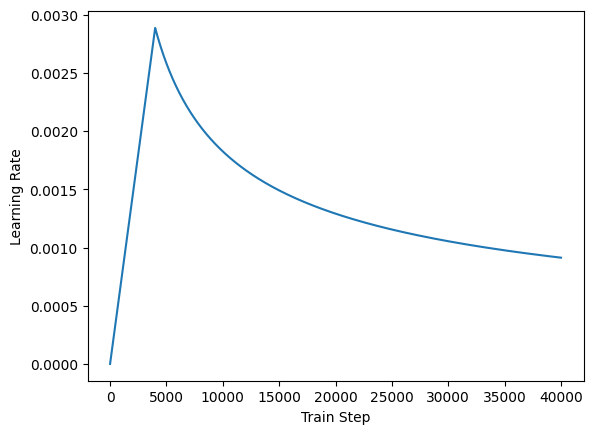

In [ ]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')
plt.savefig(checkpoint_dir+'learning_rate_plot.png')

Instantiate the optimizer (in this example it's `tf.keras.optimizers.Adam`):

With all the components ready, configure the training procedure using `model.compile`, and then run it with `model.fit`:

Note: This takes about an hour to train in Colab.

##Save best model

In [ ]:

checkpoint_filepath = checkpoint_dir +model_base_name +'.{epoch:02d}-{val_accuracy:.2f}'
checkpoint_filepath

'./Final_Work/enhanced_cleaned_data_base_tx_4_heads_dsize_30/cl_enh_dat_bl_tx_w_rand_embed_dsize_30.{epoch:02d}-{val_accuracy:.2f}'

In [ ]:
from keras import losses


callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath, #checkpoint_filepath define earlier in this notebook
        monitor="val_loss", #'val_loss'
        save_best_only=False,
        save_weights_only=True,  # Add this line
    )
]


####Compile the Model

In [ ]:

transformer.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'],
    run_eagerly=True)


####Start Training

Epoch 1/10
84/84 [==============================] - 23s 275ms/step - loss: 1.1209 - accuracy: 0.4594 - val_loss: 0.6842 - val_accuracy: 0.5771
Epoch 2/10
84/84 [==============================] - 23s 277ms/step - loss: 0.7217 - accuracy: 0.5359 - val_loss: 0.6781 - val_accuracy: 0.5784
Epoch 3/10
84/84 [==============================] - 23s 278ms/step - loss: 0.6958 - accuracy: 0.5429 - val_loss: 0.6716 - val_accuracy: 0.5814
Epoch 4/10
84/84 [==============================] - 23s 272ms/step - loss: 0.6776 - accuracy: 0.5699 - val_loss: 0.6472 - val_accuracy: 0.6563
Epoch 5/10
84/84 [==============================] - 23s 270ms/step - loss: 0.5991 - accuracy: 0.6836 - val_loss: 0.5478 - val_accuracy: 0.7509
Epoch 6/10
84/84 [==============================] - 22s 266ms/step - loss: 0.4605 - accuracy: 0.7844 - val_loss: 0.4990 - val_accuracy: 0.7877
Epoch 7/10
84/84 [==============================] - 23s 272ms/step - loss: 0.3932 - accuracy: 0.8277 - val_loss: 0.4679 - val_accuracy: 0.7973

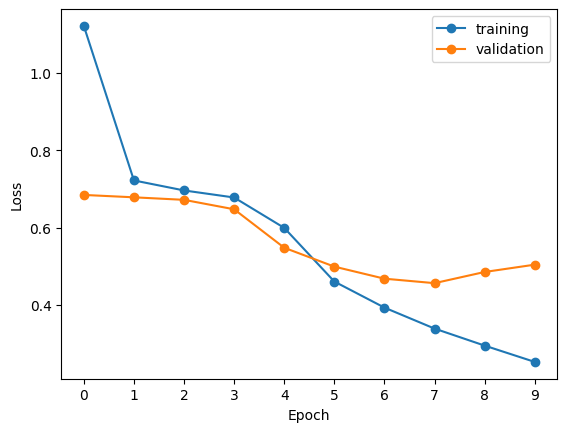

In [ ]:
history = transformer.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks_list)

# Convert the return value into a DataFrame so we can see the train loss
# and binary accuracy after every epoch.
history = pd.DataFrame(history.history)
plot_history(history, checkpoint_dir)
history_to_csv(history, num_layers, d_model, num_heads, dff, dropout_rate, model_base_name, load_data, checkpoint_dir)


####Document and summarize results in a CSV File

#Memory Clean Up

In [ ]:
del transformer

#End of File